In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from functools import reduce
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(style="whitegrid")

#### Read in suicide data

In [2]:
deaths = pd.read_csv('suicides_2018.txt', delimiter='\t')

#### group by county code and sum deaths that used different codes

In [3]:
county_code_total_suicides = deaths.groupby(['County Code'])['Deaths'].sum().reset_index()

In [4]:
county_code_total_suicides.head()

,County Code,Deaths
0,1003.0,33.0
1,1015.0,19.0
2,1033.0,10.0
3,1045.0,10.0
4,1049.0,10.0


#### Read in unemployment data

In [5]:
unemployment = pd.read_excel('laucnty18.xlsx', header=2)

#### Make column names mostly useful

In [6]:
unemployment.rename(columns={'Unnamed: 0':'weird_code', 'State': 'state_code', 'County': 'county_code_segment', 'Unnamed: 3': 'county_and_state', 'Unnamed: 4': 'year', 'Unnamed: 5': '?', 'Unnamed: 6': 'total_labor_force', 'Unnamed: 7': 'employed', 'Unnamed: 8': 'unemployed', 'Unemploy-': 'unemployment_rate' }, inplace=True)

In [7]:
unemployment.drop([0,1,2], inplace=True)

#### Create 'County Code' (formated to match unemployment data) from current state and county code

In [8]:
unemployment['County Code'] = unemployment['state_code'] + unemployment['county_code_segment']

In [9]:
unemployment['County Code'] = pd.to_numeric(unemployment['County Code'])

#### Isolate unemployment rate without county code

In [10]:
unemployment_rate_county_code = unemployment[['County Code', 'unemployment_rate']]

#### Read in income and education data

In [11]:
earnings_education = pd.read_csv('analytic_data2018_0.csv', low_memory=False)

In [12]:
earnings_education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Columns: 508 entries, State FIPS Code to Population growth raw value
dtypes: object(508)
memory usage: 12.4+ MB


#### fuck that's a lot of columns...

In [13]:
earnings_education.head()

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,...,Male population 18-44 raw value,Male population 45-64 raw value,Male population 65+ raw value,Total male population raw value,Female population 0-17 raw value,Female population 18-44 raw value,Female population 45-64 raw value,Female population 65+ raw value,Total female population raw value,Population growth raw value
0,statecode,countycode,fipscode,state,county,year,county_ranked,v001_rawvalue,v001_numerator,v001_denominator,...,v013_rawvalue,v016_rawvalue,v017_rawvalue,v025_rawvalue,v026_rawvalue,v027_rawvalue,v031_rawvalue,v032_rawvalue,v035_rawvalue,v097_rawvalue
1,00,000,00000,US,United States,2018,NaN,6658.1139453,3537400,896862151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01,000,01000,AL,Alabama,2018,NaN,9642.4120328,76851,13617223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01,001,01001,AL,Autauga County,2018,1,9409.2947663,851,156697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01,003,01003,AL,Baldwin County,2018,1,7467.5966638,2740,554671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
earnings_education.drop(axis=0, index=[0,1], inplace=True)

In [17]:
earnings_education['County Code'] = pd.to_numeric(earnings_education['5-digit FIPS Code'])

### Merge all dataframes

In [18]:
dfs = [unemployment_rate_county_code, earnings_education, county_code_total_suicides]

In [19]:
merged = reduce(lambda left,right: pd.merge(left,right,on='County Code'), dfs)


In [20]:
def clear_low_columns(df):
    for col in df.columns:
        if df[col].isna().sum() >= 100:
            df.drop(columns=col, inplace=True)

In [21]:
clear_low_columns(merged)

In [22]:
def replace_na_with_col_median(df):
    for col in df.columns:
        if df[col].isna().any():
            df.fillna(merged[col].median(), inplace=True)

In [23]:
replace_na_with_col_median(merged)

In [26]:
merged.isna().any().sum()

0

In [27]:
merged['Population raw value'] = pd.to_numeric(merged['Population raw value'])

### Create target variable (suicides in relation to population)

In [28]:
merged['suicides_per_100k_pop'] = merged['Deaths'] / (merged['Population raw value']/100000)

In [29]:
non_int_colums = ['State Abbreviation', 'Name']

In [30]:
columns = np.array(merged.columns)

In [31]:
int_columns = [x for x in columns if x not in non_int_colums]

In [32]:
full_df = merged[int_columns].apply(pd.to_numeric)

#### Format columns to work with ols formula

In [33]:
full_df.columns = [col.replace(' ', '_').replace('%', 'percent').replace('-', '_').replace('(', "").replace(")", "") for col in full_df.columns]

### Feature engineering

#### Create categorical variables from % of populations

In [34]:
full_df['above_average_hispanic_population'] = np.where(full_df['percent_Hispanic_raw_value'] > full_df['percent_Hispanic_raw_value'].median(), 1, 0)

In [35]:
full_df['above_average_black_population'] = np.where(full_df['percent_Non_Hispanic_African_American_raw_value'] > full_df['percent_Non_Hispanic_African_American_raw_value'].median(), 1, 0)

In [36]:
full_df['above_average_child_population'] = np.where(full_df['percent_below_18_years_of_age_raw_value'] > full_df['percent_below_18_years_of_age_raw_value'].median(), 1, 0)

In [37]:
full_df['above_average_elderly_population'] = np.where(full_df['percent_65_and_older_raw_value'] > full_df['percent_65_and_older_raw_value'].median(), 1, 0)

In [38]:
full_df['above_average_native_population'] = np.where(full_df['percent_American_Indian_and_Alaskan_Native_raw_value'] > full_df['percent_American_Indian_and_Alaskan_Native_raw_value'].median(), 1, 0)

In [39]:
full_df['above_average_native_HI_population'] = np.where(full_df['percent_Native_Hawaiian/Other_Pacific_Islander_raw_value'] > full_df['percent_Native_Hawaiian/Other_Pacific_Islander_raw_value'].median(), 1, 0)

In [40]:
full_df['above_average_asian_population'] = np.where(full_df['percent_Asian_raw_value'] > full_df['percent_Asian_raw_value'].median(), 1, 0)

In [41]:
full_df['above_average_white_population'] = np.where(full_df['percent_Non_Hispanic_white_raw_value'] > full_df['percent_Non_Hispanic_white_raw_value'].median(), 1, 0)

In [42]:
full_df['above_average_female_population'] = np.where(full_df['percent_Females_raw_value'] > full_df['percent_Females_raw_value'].median(), 1, 0)

In [43]:
full_df['above_average_rural_population'] = np.where(full_df['percent_Rural_raw_value'] > full_df['percent_Rural_raw_value'].median(), 1, 0)

In [44]:
target = full_df['suicides_per_100k_pop']

In [47]:
features = full_df[['unemployment_rate', 'above_average_rural_population', 'above_average_female_population','above_average_white_population','above_average_black_population','above_average_hispanic_population','above_average_asian_population','above_average_native_population','above_average_native_HI_population','above_average_elderly_population', 'above_average_child_population', 'Disconnected_youth_raw_value']]

### Check correlations with target

In [48]:
features.corrwith(target).reset_index()

,index,0
0,unemployment_rate,0.121931
1,above_average_rural_population,0.255224
2,above_average_female_population,-0.094560
3,above_average_white_population,0.126033
4,above_average_black_population,-0.160615
5,above_average_hispanic_population,0.009953
6,above_average_asian_population,-0.346510
7,above_average_native_population,0.128209
8,above_average_native_HI_population,0.094373
9,above_average_elderly_population,0.206541


#### Get data for each subpopulation

In [49]:
asian_data = full_df.loc[full_df['above_average_asian_population'] == 1]
hispanic_data = full_df.loc[full_df['above_average_hispanic_population'] == 1]
black_data = full_df.loc[full_df['above_average_black_population'] == 1]
white_data = full_df.loc[full_df['above_average_white_population'] == 1]
native_us_data = full_df.loc[full_df['above_average_native_population'] == 1]
native_HI_data = full_df.loc[full_df['above_average_native_HI_population'] == 1]

In [50]:
populations = [asian_data, hispanic_data, black_data, white_data, native_us_data, native_HI_data]

### Plot suicide rate for each population

In [51]:
average_suicide_rate_full_population = full_df['suicides_per_100k_pop'].mean()

race_average_values = [average_suicide_rate_full_population, asian_data['suicides_per_100k_pop'].mean(), hispanic_data['suicides_per_100k_pop'].mean(), black_data['suicides_per_100k_pop'].mean(), white_data['suicides_per_100k_pop'].mean(), native_us_data['suicides_per_100k_pop'].mean(), native_HI_data['suicides_per_100k_pop'].mean()]


Text(0.5, 1.0, 'Comparing Areas With Higher Than Average of Given Race to Suicide Rate')

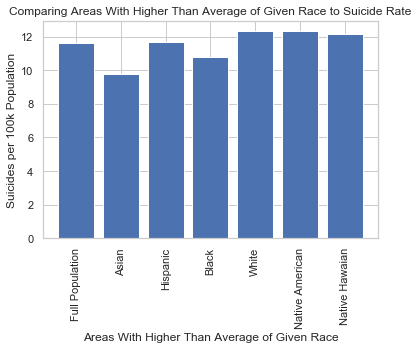

In [52]:
fig, ax = plt.subplots()
ax.bar(['Full Population', 'Asian', 'Hispanic', 'Black', 'White', 'Native American', 'Native Hawaian'], race_average_values)
plt.xticks(rotation=90)
ax.set_ylabel('Suicides per 100k Population')
ax.set_xlabel('Areas With Higher Than Average of Given Race')
ax.set_title('Comparing Areas With Higher Than Average of Given Race to Suicide Rate')